# Set up

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm

# Load Data

In [18]:
X_train, y_train = torch.load("data/brats_train.pt")
X_val, y_val = torch.load("data/brats_val.pt")
X_test, y_test = torch.load("data/brats_test.pt")

# Preprocess

In [19]:
class BraTSDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]  # (C, H, W), already normalized
        mask = self.y[idx]  # (H, W)

        if torch.any(mask > 3):
            print(f"Sample {idx} has label > 3. Clamping.")
            mask = torch.clamp(mask, 0, 3)

        if self.transform:
            img = self.transform(img)

        return img, mask


In [20]:
# Transform pipeline
# transform = tio.Compose([
#     # tio.Resize((1, 256, 256)),                  # Only if CUDA out of memory
#     tio.RescaleIntensity(percentiles=(0, 99)),  # Percentile stretching
#     # tio.ZNormalization(),                       # Standardization
# ])

train_dataset = BraTSDataset(X_train, y_train)
test_dataset = BraTSDataset(X_test, y_test)

img, mask = train_dataset[0]
print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')  # (B, C, H, W)

Image shape: torch.Size([3, 128, 128]), Mask shape: torch.Size([128, 128])


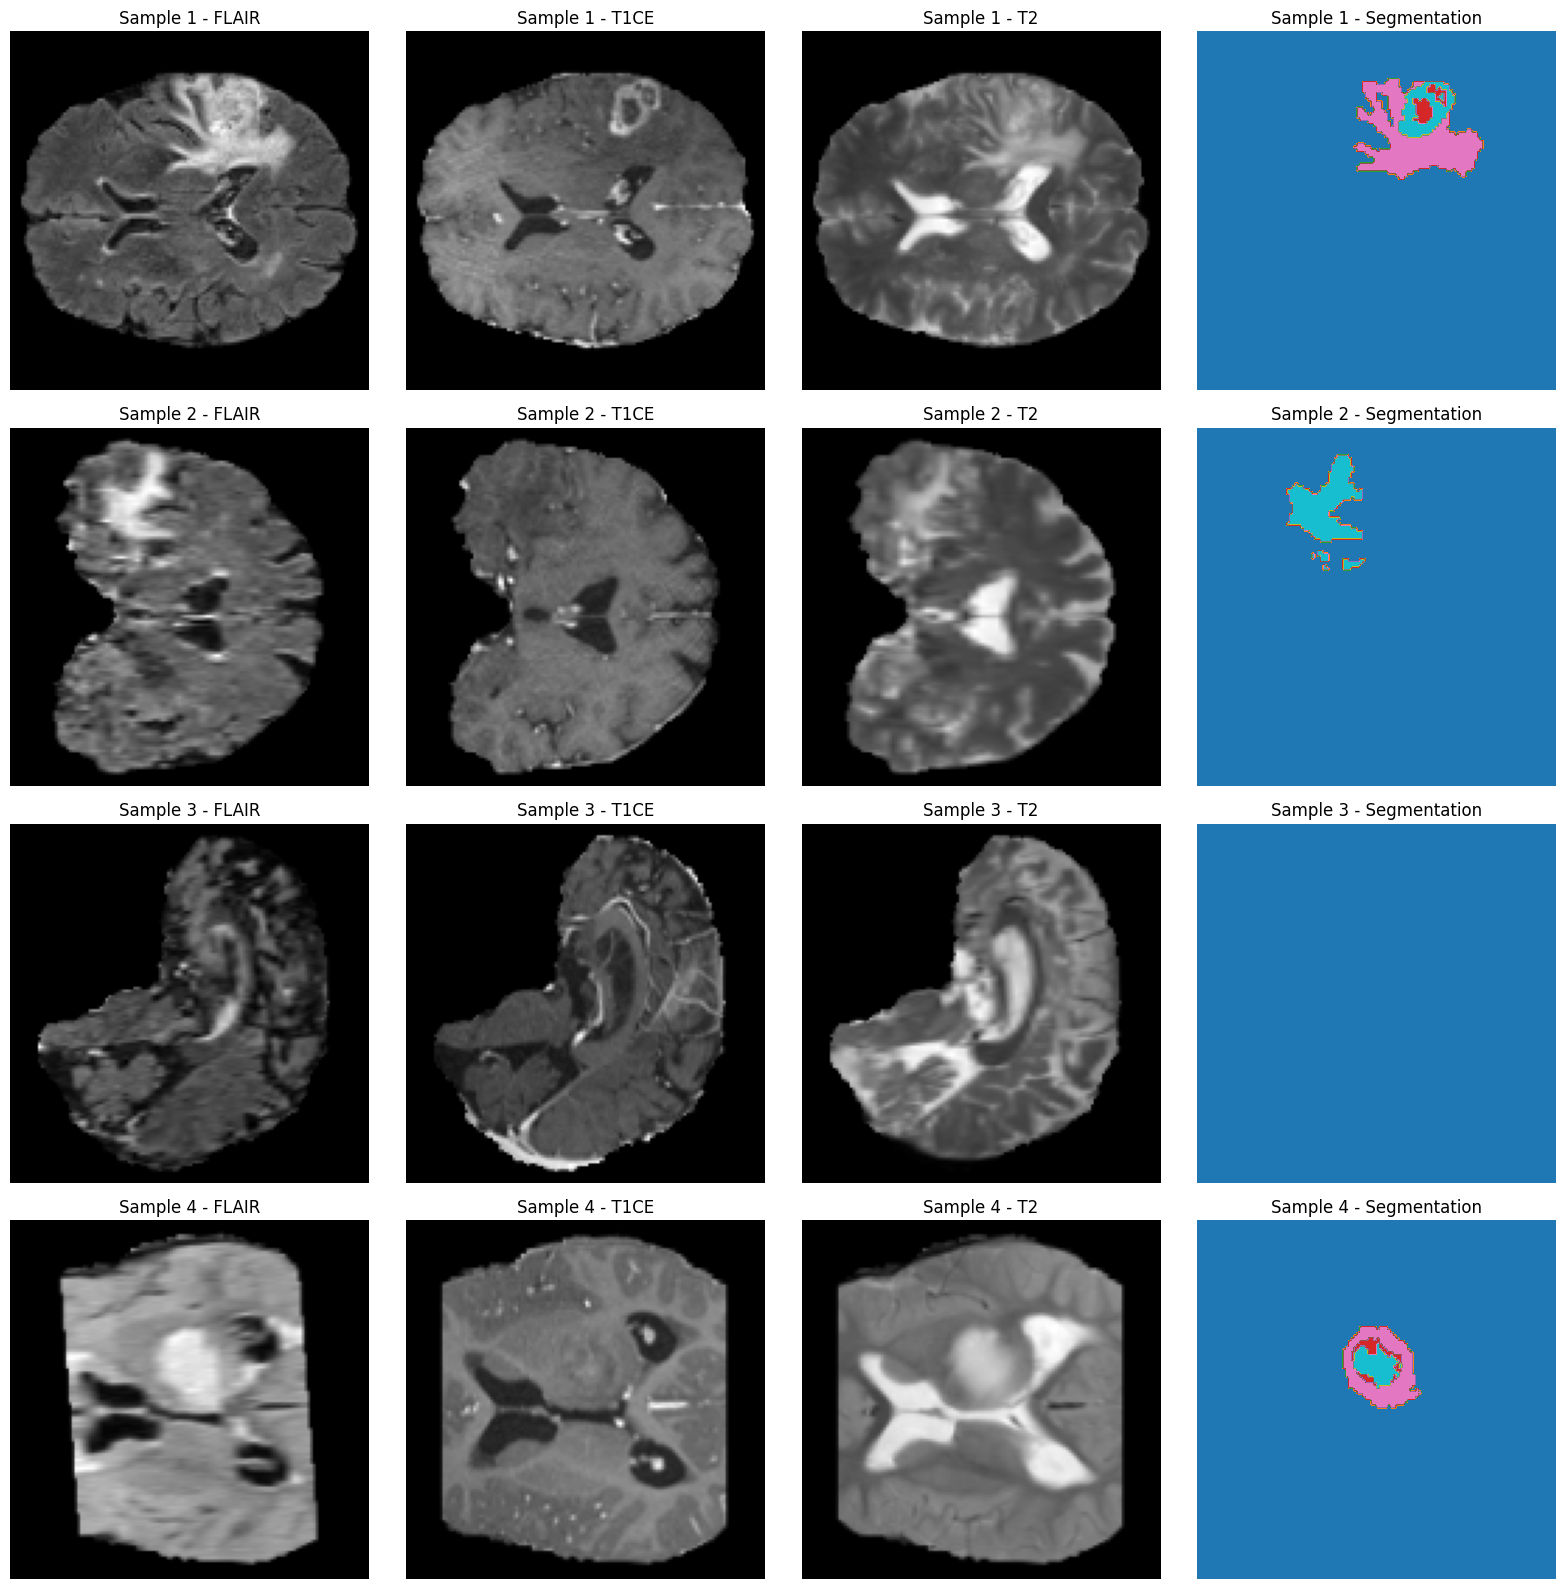

In [21]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))  # 3 inputs + 1 mask

    for i in range(num_samples):
        img, mask = dataset[i] # img: (3, H, W), mask: (H, W)
        img = img.cpu().numpy()
        mask = mask.cpu().numpy()

        flair = img[0]
        t1ce = img[1]
        t2 = img[2]

        axes[i, 0].imshow(flair, cmap='gray')
        axes[i, 0].set_title(f'Sample {i+1} - FLAIR')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(t1ce, cmap='gray')
        axes[i, 1].set_title(f'Sample {i+1} - T1CE')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(t2, cmap='gray')
        axes[i, 2].set_title(f'Sample {i+1} - T2')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(mask, cmap=ListedColormap(['black', 'red', 'green', 'yellow']))
        axes[i, 3].set_title(f'Sample {i+1} - Segmentation')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples from the training dataset
plot_samples(train_dataset, num_samples=4)

# Modified UNet++

In [22]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.residual_conv = None

    def forward(self, x):
        x = x.float()
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.residual_conv:
            residual = self.residual_conv(residual)
        out += residual  # Add the residual connection
        out = self.relu(out)
        return out


class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(UNetPlusPlus, self).__init__()
        out_channels = [64, 128, 256, 512, 1024]

        # Backbone
        self.conv0_0 = ConvBlock(in_channels, out_channels[0], out_channels[0])
        self.conv1_0 = ConvBlock(out_channels[0], out_channels[1], out_channels[1])
        self.conv2_0 = ConvBlock(out_channels[1], out_channels[2], out_channels[2])
        self.conv3_0 = ConvBlock(out_channels[2], out_channels[3], out_channels[3])
        self.conv4_0 = ConvBlock(out_channels[3], out_channels[4], out_channels[4])

        # Skip pathways
        self.conv0_1 = ConvBlock(out_channels[0]+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_1 = ConvBlock(out_channels[1]+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_1 = ConvBlock(out_channels[2]+out_channels[3], out_channels[2], out_channels[2])
        self.conv3_1 = ConvBlock(out_channels[3]+out_channels[4], out_channels[3], out_channels[3])

        self.conv0_2 = ConvBlock(out_channels[0]*2+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_2 = ConvBlock(out_channels[1]*2+out_channels[2], out_channels[1], out_channels[1])
        self.conv2_2 = ConvBlock(out_channels[2]*2+out_channels[3], out_channels[2], out_channels[2])

        self.conv0_3 = ConvBlock(out_channels[0]*3+out_channels[1], out_channels[0], out_channels[0])
        self.conv1_3 = ConvBlock(out_channels[1]*3+out_channels[2], out_channels[1], out_channels[1])

        self.conv0_4 = ConvBlock(out_channels[0]*4 + out_channels[1], out_channels[0], out_channels[0])

        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2, 2)
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Classifier
        self.final = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Backbone
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Input = previous conv + upsample lower conv
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_sample(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up_sample(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up_sample(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up_sample(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_sample(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up_sample(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up_sample(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_sample(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up_sample(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_sample(x1_3)], 1))
        output = self.final(x0_4)
        return output

# Loss

In [23]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.eps = torch.finfo(torch.float32).eps

    def forward(self, predict, target):
        predict = F.softmax(predict, dim=1)
        num_classes = predict.shape[1]
        dice = 0.0

        for c in range(num_classes):
            pred_flat = predict[:, c, :, :].contiguous().view(-1)
            target_flat = (target == c).float().view(-1)
            intersection = torch.sum(pred_flat * target_flat)
            union = torch.sum(pred_flat) + torch.sum(target_flat)
            dice_class = (2 * intersection + self.eps) / (union + self.eps)
            dice += 1 - dice_class

        return dice / num_classes


class DiceCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, class_weights=None):
        super(DiceCELoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, predict, target):
        dice = self.dice_loss(predict.float(), target.float())
        ce_target = F.one_hot(target.squeeze(1).long(), num_classes=4).permute(0,3,1,2)
        ce = self.ce_loss(predict.float(), ce_target.float())
        return self.dice_weight * dice + (1 - self.dice_weight) * ce

In [24]:
def IoU(pred_masks, true_masks):
    total_iou = 0
    num_classes = pred_masks.shape[1]
    pred_probs = torch.softmax(pred_masks, dim=1)

    for class_idx in range(num_classes):
        pred_mask = (torch.argmax(pred_probs.float(), dim=1) == class_idx).float()
        # true_mask = (true_masks[:, 0, :, :] == class_idx).float()
        true_mask = (true_masks == class_idx).float()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union if union != 0 else 1  # Correct empty prediction
        total_iou += iou

    return total_iou / num_classes

# Training and Testing

In [37]:
def train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every=None):
    try:
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0
            total_iou = 0.0
            num_samples = 0

            for batch_idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = batch
                inputs = inputs.to(device, dtype=dtype)
                labels = labels.to(device, dtype=dtype)

                optimizer.zero_grad()
                out = model(inputs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()

                with torch.no_grad():  # Disable gradient calculation
                    iou = IoU(out, labels)
                    total_iou += iou * inputs.size(0)
                    num_samples += inputs.size(0)

                total_loss += loss.item() * inputs.size(0)

                if print_every is not None and batch_idx % print_every == 0:
                    print('  Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), iou))

            average_loss = total_loss / num_samples
            average_iou = total_iou / num_samples
            print('  Average Loss: {:.4f}, Average IoU: {:.4f}'.format(average_loss, average_iou))

        torch.save(model, save_path)

    except Exception as e:
        print(e)
        torch.save(model, save_path)

In [26]:
def test(model, val_loader, criterion, device, dtype):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device, dtype=dtype)
            labels = labels.to(device, dtype=dtype)

            out = model(inputs)
            loss = criterion(out, labels)
            iou = IoU(out, labels)

            total_iou += iou * inputs.size(0)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)

        average_loss = total_loss/num_samples
        average_iou = total_iou/num_samples

        print('Test Loss: {:.4f}, Test IoU: {:.4f}'.format(average_loss, average_iou))

In [79]:
def compute_class_weights(y_train, num_classes):
    y_flat = y_train.view(-1)
    counts = torch.bincount(y_flat, minlength=num_classes).float()
    total = counts.sum()
    weights = total / counts
    return weights / weights.sum()

print(f"Train class weights ~ {compute_class_weights(y_train, 4)}")
print(f"Test class weights  ~ {compute_class_weights(y_test, 4)}")

Train class weights ~ tensor([0.0041, 0.4005, 0.1614, 0.4341])
Test test weights   ~ tensor([0.0042, 0.3108, 0.1400, 0.5449])


In [80]:
# def pure_bg(dataset):
#     pure_bg = (dataset == 0).view(dataset.size(0), -1).all(dim=1)
#     return pure_bg.sum().item()

# print(f"Number of fully class 0 train images : {pure_bg(y_train)}/{y_train.shape[0]}")
# print(f"Number of fully class 0 test images  : {pure_bg(y_test)}/{y_test.shape[0]}")

Number of fully class 0 train images : 200/747
Number of fully class 0 test images  : 30/135


In [56]:
# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print_every = None

input_channels = 3
num_classes = 4
class_weights = compute_class_weights(y_train, num_classes).to(device)
dice_weight = 0.5
learning_rate = 0.001
batch_size = 16
num_epochs = 50

save_path = f'checkpoints/runet++_dce{dice_weight:.0e}_invfreqw_adam{learning_rate:.0e}_batch{batch_size}_epoch{num_epochs}.pth'.replace('+0', '').replace('-0', '-')
model = UNet(num_classes, input_channels)
class_weights = compute_class_weights(y_train, num_classes).to(device)
criterion = DiceCELoss(dice_weight=dice_weight, class_weights=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

print(save_path)

In [57]:
# from torch.utils.data import Subset
# train_subset = Subset(train_dataset, list(range(8)))
# train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every)

Epoch 1/40: 100%|██████████| 1/1 [00:11<00:00, 11.97s/it]


Average Loss: 0.2666, Average IoU: 0.2174


Epoch 2/40: 100%|██████████| 1/1 [00:14<00:00, 14.77s/it]


Average Loss: 0.2440, Average IoU: 0.2651


Epoch 3/40: 100%|██████████| 1/1 [00:14<00:00, 14.58s/it]


Average Loss: 0.2212, Average IoU: 0.3301


Epoch 4/40: 100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


Average Loss: 0.1967, Average IoU: 0.3524


Epoch 5/40: 100%|██████████| 1/1 [00:14<00:00, 14.59s/it]


Average Loss: 0.2018, Average IoU: 0.3237


Epoch 6/40: 100%|██████████| 1/1 [00:14<00:00, 14.96s/it]


Average Loss: 0.1654, Average IoU: 0.4329


Epoch 7/40: 100%|██████████| 1/1 [00:14<00:00, 14.48s/it]


Average Loss: 0.2120, Average IoU: 0.3437


Epoch 8/40: 100%|██████████| 1/1 [00:14<00:00, 14.65s/it]


Average Loss: 0.1415, Average IoU: 0.4824


Epoch 9/40: 100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


Average Loss: 0.1355, Average IoU: 0.5091


Epoch 10/40: 100%|██████████| 1/1 [00:14<00:00, 14.52s/it]


Average Loss: 0.1252, Average IoU: 0.5207


Epoch 11/40: 100%|██████████| 1/1 [00:14<00:00, 14.62s/it]


Average Loss: 0.1429, Average IoU: 0.4783


Epoch 12/40: 100%|██████████| 1/1 [00:15<00:00, 15.05s/it]


Average Loss: 0.1265, Average IoU: 0.5077


Epoch 13/40: 100%|██████████| 1/1 [00:14<00:00, 14.46s/it]


Average Loss: 0.1348, Average IoU: 0.4765


Epoch 14/40: 100%|██████████| 1/1 [00:14<00:00, 14.52s/it]


Average Loss: 0.1292, Average IoU: 0.5227


Epoch 15/40: 100%|██████████| 1/1 [00:14<00:00, 14.96s/it]


Average Loss: 0.1187, Average IoU: 0.5221


Epoch 16/40: 100%|██████████| 1/1 [00:14<00:00, 14.61s/it]


Average Loss: 0.1072, Average IoU: 0.5651


Epoch 17/40: 100%|██████████| 1/1 [00:14<00:00, 14.49s/it]


Average Loss: 0.1019, Average IoU: 0.5731


Epoch 18/40: 100%|██████████| 1/1 [00:14<00:00, 14.93s/it]


Average Loss: 0.1044, Average IoU: 0.5779


Epoch 19/40: 100%|██████████| 1/1 [00:14<00:00, 14.49s/it]


Average Loss: 0.0905, Average IoU: 0.6392


Epoch 20/40: 100%|██████████| 1/1 [00:14<00:00, 14.53s/it]


Average Loss: 0.0995, Average IoU: 0.6047


Epoch 21/40: 100%|██████████| 1/1 [00:14<00:00, 14.92s/it]


Average Loss: 0.0906, Average IoU: 0.6289


Epoch 22/40: 100%|██████████| 1/1 [00:14<00:00, 14.46s/it]


Average Loss: 0.0872, Average IoU: 0.6310


Epoch 23/40: 100%|██████████| 1/1 [00:14<00:00, 14.54s/it]


Average Loss: 0.0873, Average IoU: 0.6235


Epoch 24/40: 100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


Average Loss: 0.0823, Average IoU: 0.6396


Epoch 25/40: 100%|██████████| 1/1 [00:14<00:00, 14.44s/it]


Average Loss: 0.0793, Average IoU: 0.6582


Epoch 26/40: 100%|██████████| 1/1 [00:14<00:00, 14.57s/it]


Average Loss: 0.0759, Average IoU: 0.6799


Epoch 27/40: 100%|██████████| 1/1 [00:14<00:00, 14.93s/it]


Average Loss: 0.0745, Average IoU: 0.6761


Epoch 28/40: 100%|██████████| 1/1 [00:14<00:00, 14.48s/it]


Average Loss: 0.0699, Average IoU: 0.6903


Epoch 29/40: 100%|██████████| 1/1 [00:14<00:00, 14.49s/it]


Average Loss: 0.0694, Average IoU: 0.6931


Epoch 30/40: 100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


Average Loss: 0.0654, Average IoU: 0.7145


Epoch 31/40: 100%|██████████| 1/1 [00:14<00:00, 14.44s/it]


Average Loss: 0.0620, Average IoU: 0.7308


Epoch 32/40: 100%|██████████| 1/1 [00:14<00:00, 14.51s/it]


Average Loss: 0.0619, Average IoU: 0.7322


Epoch 33/40: 100%|██████████| 1/1 [00:14<00:00, 14.87s/it]


Average Loss: 0.0595, Average IoU: 0.7360


Epoch 34/40: 100%|██████████| 1/1 [00:14<00:00, 14.54s/it]


Average Loss: 0.0571, Average IoU: 0.7454


Epoch 35/40: 100%|██████████| 1/1 [00:14<00:00, 14.49s/it]


Average Loss: 0.0555, Average IoU: 0.7524


Epoch 36/40: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


Average Loss: 0.0542, Average IoU: 0.7565


Epoch 37/40: 100%|██████████| 1/1 [00:14<00:00, 14.46s/it]


Average Loss: 0.0530, Average IoU: 0.7589


Epoch 38/40: 100%|██████████| 1/1 [00:14<00:00, 14.52s/it]


Average Loss: 0.0521, Average IoU: 0.7620


Epoch 39/40: 100%|██████████| 1/1 [00:14<00:00, 14.89s/it]


Average Loss: 0.0507, Average IoU: 0.7679


Epoch 40/40: 100%|██████████| 1/1 [00:14<00:00, 14.49s/it]


Average Loss: 0.0493, Average IoU: 0.7694


# Visualize Segmentation Results

In [60]:
# Load the saved model
saved_model_path = 'checkpoints/runet++_dce3_adam_batch16_epoch30.pth'
loaded_model = torch.load(saved_model_path)
loaded_model.eval()
loaded_model.to(device)

UNetPlusPlus(
  (conv0_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (residual_conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv1_0): ConvBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (residual_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv2_0): ConvBlock(
    (relu): ReLU(i

In [61]:
def calculate_metrics(model, dataloader, device=torch.device('cuda'), num_classes=4, eps=torch.finfo(torch.float32).eps):
    model.eval()
    total_iou = 0.0
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(imgs)  # (B, C, H, W)
            pred_masks = torch.argmax(outputs, dim=1)  # (B, H, W)

            dice_sum = 0.0
            iou_sum = 0.0
            for c in range(num_classes):
                pred_cls = (pred_masks == c).float()
                true_cls = (masks == c).float()

                intersection = torch.sum(pred_cls * true_cls)
                union = torch.sum((pred_cls + true_cls) > 0)
                iou = (intersection + eps) / (union + eps)
                dice = (2. * intersection + eps) / (torch.sum(pred_cls) + torch.sum(true_cls) + eps)

                dice_sum += dice.item()
                iou_sum += iou.item()

            total_dice += dice_sum / num_classes
            total_iou += iou_sum / num_classes
            num_samples += 1

    return {
        'IoU': total_iou / num_samples,
        'Dice': total_dice / num_samples
    }

In [62]:
# Calculate metrics on the test set
vis_test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

metrics = calculate_metrics(loaded_model, vis_test_loader, device=device)
print(f"Test IoU: {metrics['IoU']:.4f}")
print(f"Test Dice: {metrics['Dice']:.4f}")

Test IoU: 0.2598
Test Dice: 0.5376


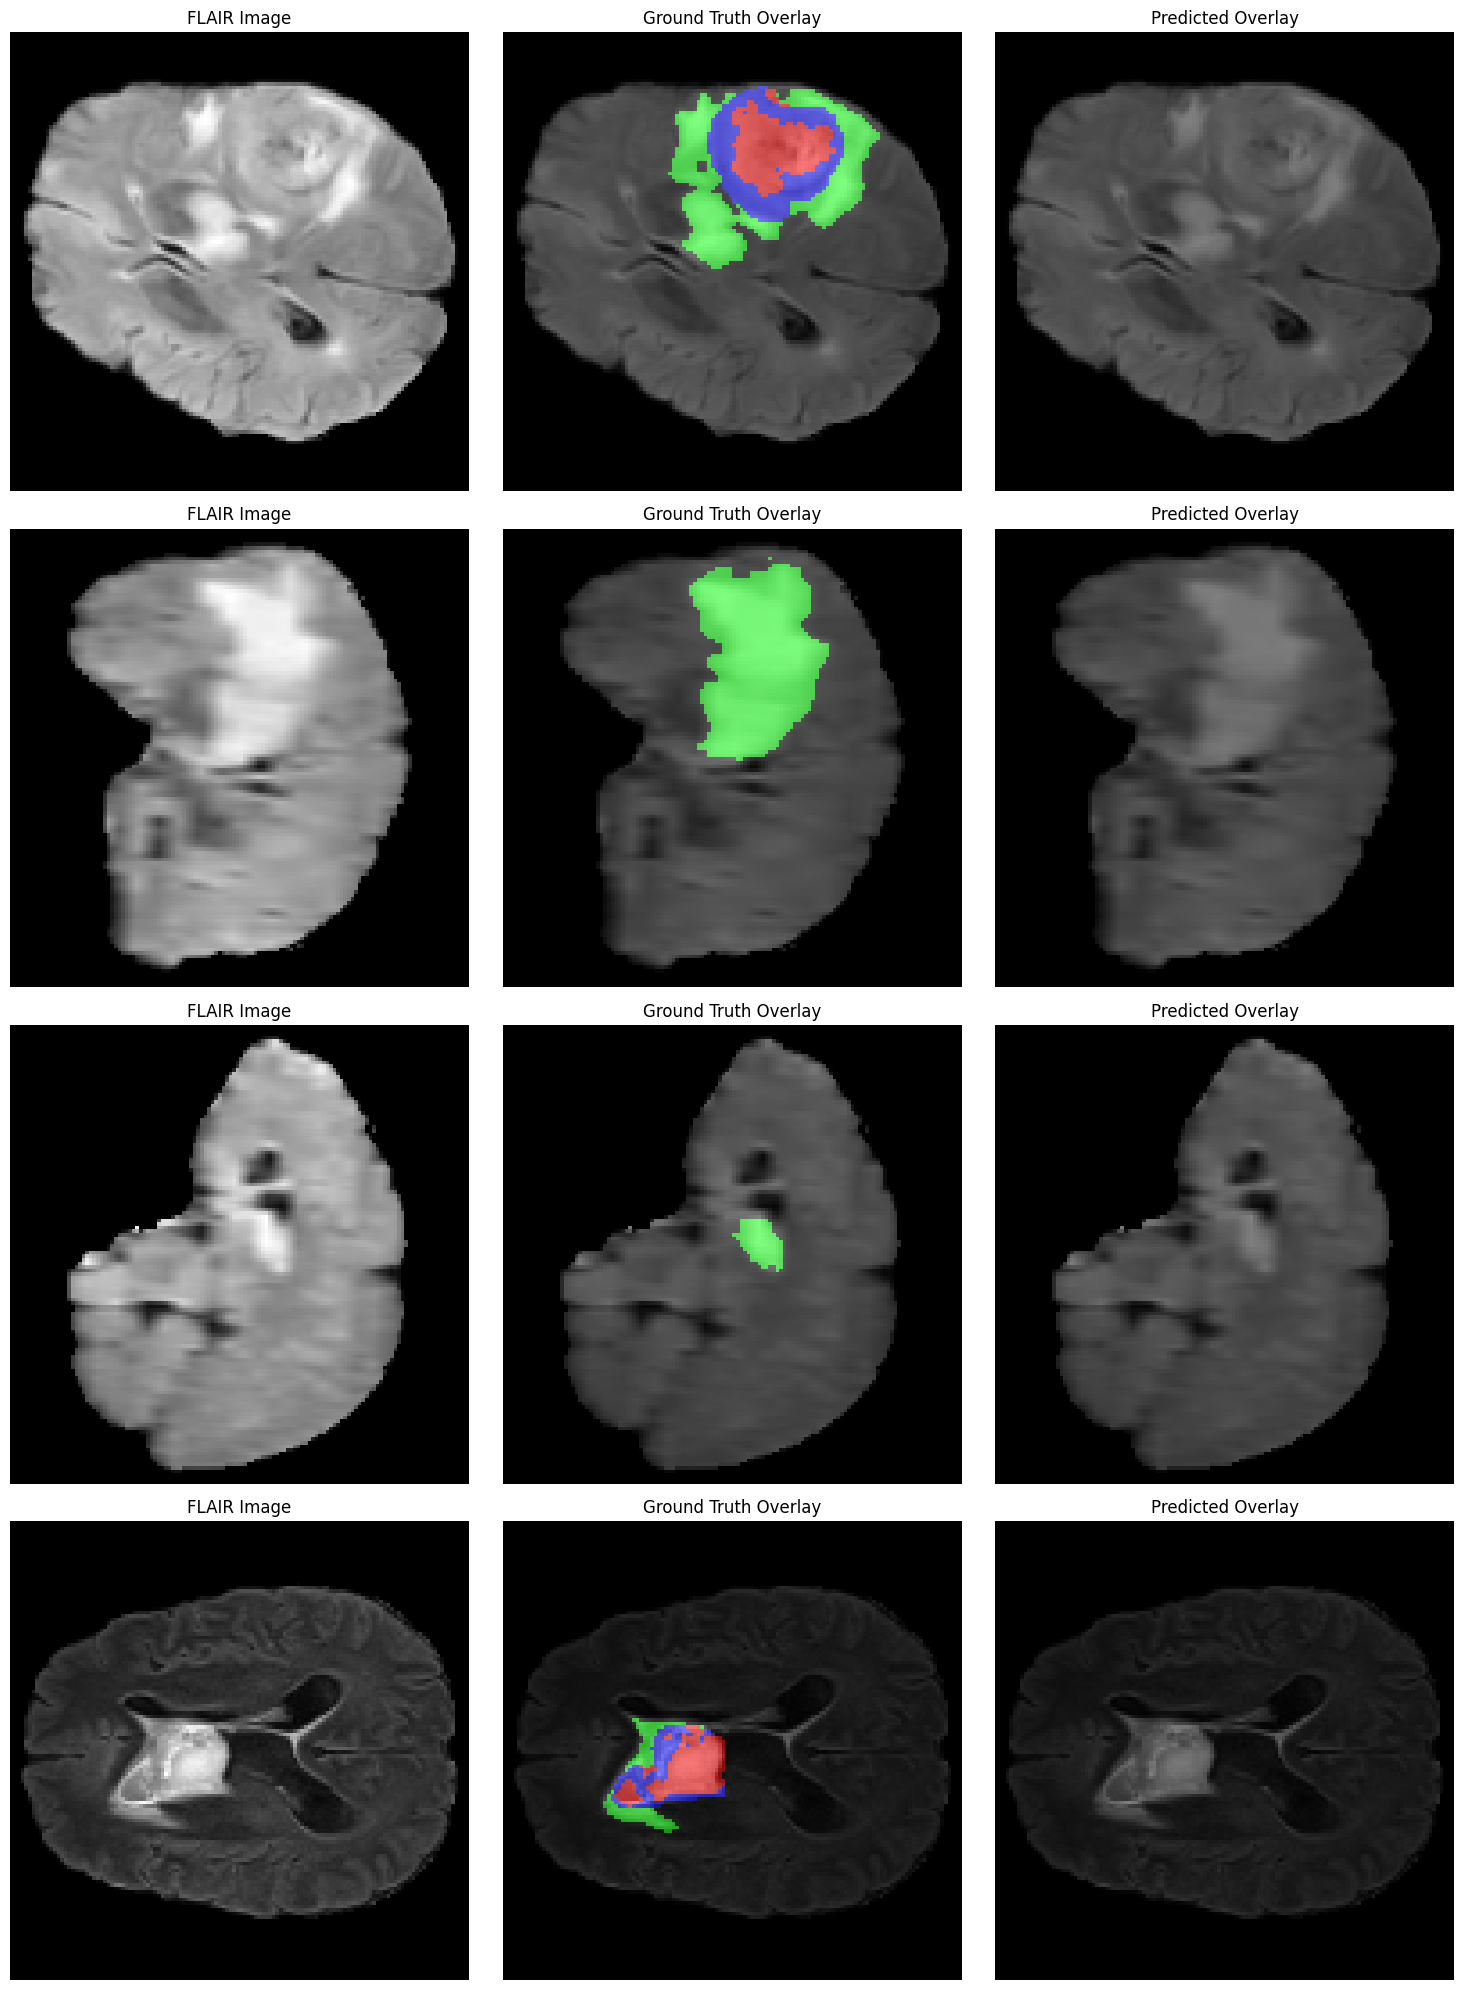

In [75]:
# Visualize segmentation overlays
def visualize_segmentation_overlay(model, dataloader, num_samples=4, device=torch.device('cuda')):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    count = 0
    with torch.no_grad():
        for images, masks in dataloader:
            batch_size = images.size(0)
            for b in range(batch_size):
                if count >= num_samples:
                    break

                image = images[b].to(device).unsqueeze(0)  # [1, 3, H, W]
                mask = masks[b].to(device)  # [H, W]

                output = model(image)  # [1, C, H, W]
                pred_mask = torch.argmax(torch.softmax(output, dim=1), dim=1)[0].cpu().numpy()
                mask_np = mask.cpu().numpy()
                flair_np = image[0, 0].cpu().numpy()

                flair_np = (flair_np - flair_np.min()) / (flair_np.max() - flair_np.min() + 1e-5)
                flair_rgb = np.stack([flair_np]*3, axis=-1)

                cmap = ListedColormap(['black', 'red', 'green', 'yellow'])
                gt_overlay = 0.5 * flair_rgb + 0.5 * cmap(mask_np)[..., :3]
                pred_overlay = 0.5 * flair_rgb + 0.5 * cmap(pred_mask)[..., :3]

                # Plotting
                axes[count, 0].imshow(flair_np, cmap='gray')
                axes[count, 0].set_title("FLAIR Image")
                axes[count, 0].axis('off')

                axes[count, 1].imshow(gt_overlay)
                axes[count, 1].set_title("Ground Truth Overlay")
                axes[count, 1].axis('off')

                axes[count, 2].imshow(pred_overlay)
                axes[count, 2].set_title("Predicted Overlay")
                axes[count, 2].axis('off')

                count += 1
            if count >= num_samples:
                break

    plt.tight_layout()
    plt.show()


visualize_segmentation_overlay(loaded_model, vis_test_loader, num_samples=4, device=device)